In [1]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

# Southern California (LA wildfires study)

## NClimGrid monthly mean of daily maxima

In [112]:
da = xr.open_dataset("data/la-fires_nclimgrid_tasmax_socal-baja.nc").tmax

In [113]:
gmst = pd.read_table("ts/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year")
gmst = gmst - gmst.loc[2025]

In [114]:
tas_jja = da.resample(time = "QS-DEC").mean().groupby("time.season")["JJA"]
tas_djf = da.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"]
tas_son = da.resample(time = "QS-DEC").mean().groupby("time.season")["SON"]
tas_mam = da.resample(time = "QS-DEC").mean().groupby("time.season")["MAM"]

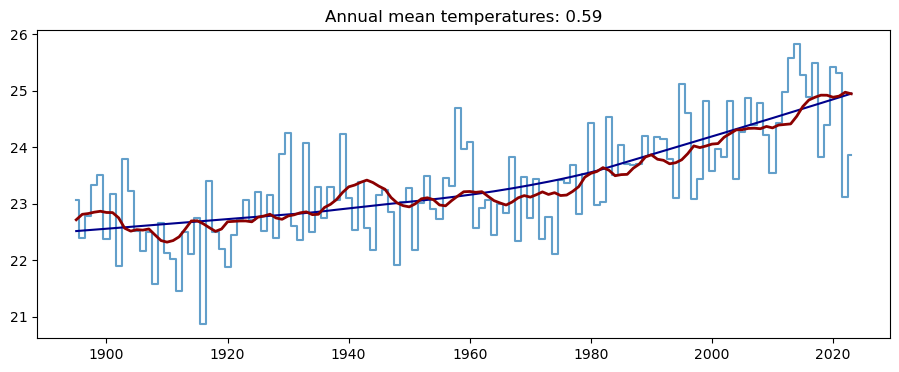

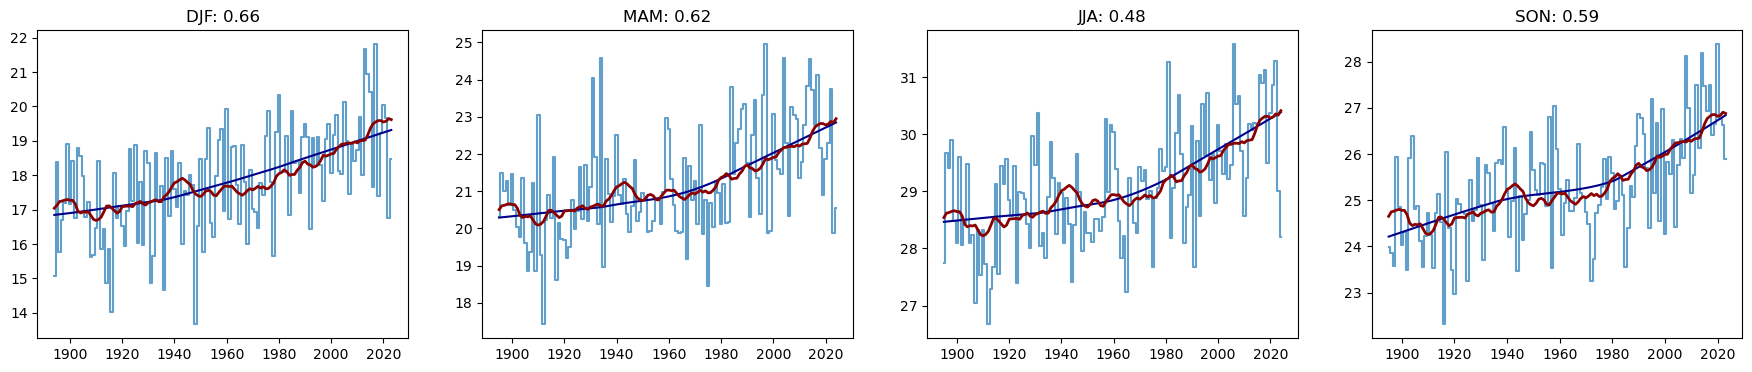

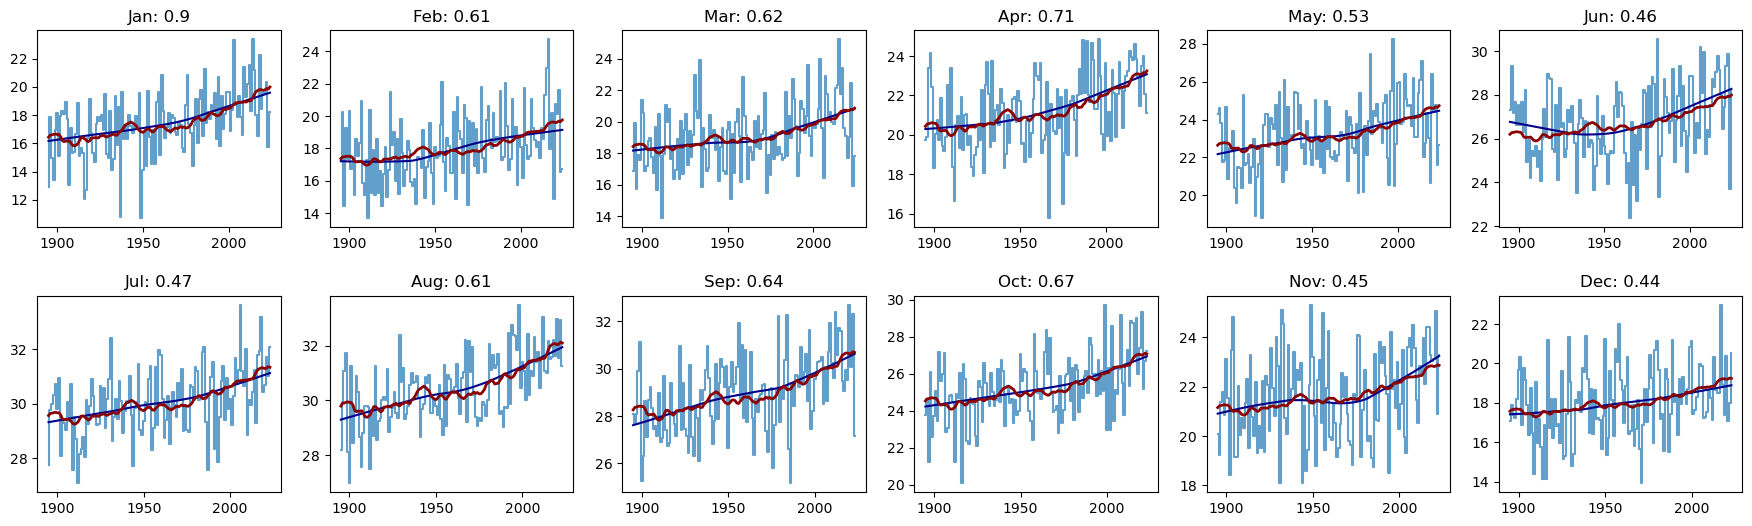

In [119]:
fig, ax = plt.subplots(ncols = 1, dpi = 100, figsize = (11,4))

ts = da.resample(time = "AS-JUL").mean().isel(time = slice(1,None))
ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")

# fit a linear trend to GMST by replacing time with gmst values
ds = xr.merge([ts, gmst.to_xarray().gmst]).dropna("year", "any")
gmst_coeffs = ds.assign_coords(year = ds.gmst.values).tmax.polyfit("year", deg = 1).polyfit_coefficients
gmst_fitted = xr.polyval(ds.gmst, gmst_coeffs)

ts.plot(ax = ax, alpha = 0.7, drawstyle = "steps-mid")
ax.plot(ts.year, lowess(ts.values, ts.year.values)[:,1], color = "darkblue")
gmst_fitted.plot(ax = ax, color = "darkred", lw = 2)

# how much have daytime max temperatures increased since 2015?
ax.set_title("Annual mean temperatures: "+str(xr.polyval(gmst.to_xarray().gmst.sel(year = [2015,2025]), gmst_coeffs).diff("year").round(2).values[0]))
ax.set_xlabel("")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 4, dpi = 100, figsize = (22,4))
for i in range(4):
    
    ax = axs[i]
    ttl = ["DJF", "MAM", "JJA", "SON"][i]
    
    ts = eval("tas_"+ttl.lower())
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
    
    # fit a linear trend to GMST by replacing time with gmst values
    ds = xr.merge([ts, gmst.to_xarray().gmst]).dropna("year", "any")
    gmst_coeffs = ds.assign_coords(year = ds.gmst.values).tmax.polyfit("year", deg = 1).polyfit_coefficients
    gmst_fitted = xr.polyval(ds.gmst, gmst_coeffs)
    
    ts.plot(ax = ax, alpha = 0.7, drawstyle = "steps-mid")
    ax.plot(ts.year, lowess(ts.values, ts.year.values)[:,1], color = "darkblue")
    gmst_fitted.plot(ax = ax, color = "darkred", lw = 2)
            
    # how much have daytime max temperatures increased since 2015?
    ax.set_title(ttl+": "+str(xr.polyval(gmst.to_xarray().gmst.sel(year = [2015,2025]), gmst_coeffs).diff("year").round(2).values[0]))
    ax.set_xlabel("")
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 6, nrows = 2, dpi = 100, figsize = (22,6), sharey = False)
plt.subplots_adjust(hspace = 0.35)
for i in range(12):
    
    ax = axs.flatten()[i]
    
    ts = da.groupby("time.month")[i+1]
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
    
    # fit a linear trend to GMST by replacing time with gmst values
    ds = xr.merge([ts, gmst.to_xarray().gmst]).dropna("year", "any")
    gmst_coeffs = ds.assign_coords(year = ds.gmst.values).tmax.polyfit("year", deg = 1).polyfit_coefficients
    gmst_fitted = xr.polyval(ds.gmst, gmst_coeffs)
    
    ts.plot(ax = ax, alpha = 0.7, drawstyle = "steps-mid")
    ax.plot(ts.year, lowess(ts.values, ts.year.values)[:,1], color = "darkblue")
    gmst_fitted.plot(ax = ax, color = "darkred", lw = 2)
            
    # how much have daytime max temperatures increased since 2015?
    ax.set_title(datetime(2024,i+1,1).strftime("%b")+": "+str(xr.polyval(gmst.to_xarray().gmst.sel(year = [2015,2025]), gmst_coeffs).diff("year").round(2).values[0]))
    ax.set_xlabel("")

In [87]:
t_change = []
for i in range(12):
        
    ts = da.groupby("time.month")[i+1]
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
    
    # fit a linear trend to GMST by replacing time with gmst values
    ds = xr.merge([ts, gmst.to_xarray().gmst]).dropna("year", "any")
    gmst_coeffs = ds.assign_coords(year = ds.gmst.values).tmax.polyfit("year", deg = 1).polyfit_coefficients
    gmst_fitted = xr.polyval(ds.gmst, gmst_coeffs)

    # how much have daytime max temperatures increased since 2015?
    t_y = xr.polyval(gmst.to_xarray().gmst.sel(year = [1980,2000,2015,2025]), gmst_coeffs)
    
    t_change.append((t_y[-1] - t_y[:-1]).rename(datetime(2024,i+1,1).strftime("%b")).to_dataframe().transpose())
    
t_change = pd.concat(t_change)

Text(0, 0.5, 'Change in 2025 vs baseline year (degC)')

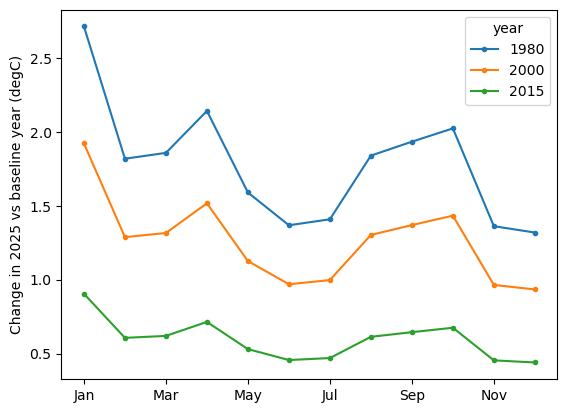

In [97]:
t_change.plot(marker = ".")
plt.ylabel("Change in 2025 vs baseline year (degC)")

In [98]:
!wget https://www.ncei.noaa.gov/data/nclimgrid-daily/access/grids/1951/ncdd-195112-grd-scaled.nc

--2025-02-04 13:32:26--  https://www.ncei.noaa.gov/data/nclimgrid-daily/access/grids/1951/ncdd-195112-grd-scaled.nc
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 2610:20:8040:2::167, 2610:20:8040:2::172, 2610:20:8040:2::171, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|2610:20:8040:2::167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63292813 (60M) [application/x-netcdf]
Saving to: ‘ncdd-195112-grd-scaled.nc’

ncdd-195112-grd-sca 100%[===================>]  60.36M  22.5MB/s    in 2.7s    

2025-02-04 13:32:31 (22.5 MB/s) - ‘ncdd-195112-grd-scaled.nc’ saved [63292813/63292813]



In [100]:
da = xr.open_dataset("ncdd-195112-grd-scaled.nc")

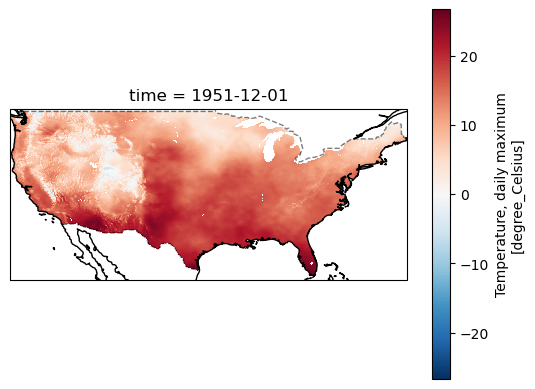

In [107]:
da.isel(time = 0).tmax.plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()})

plt.gca().add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
plt.gca().coastlines()